# Exploiting the nested sampling

In [1]:
import orsa
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

print(orsa.__version__)

0.8.7


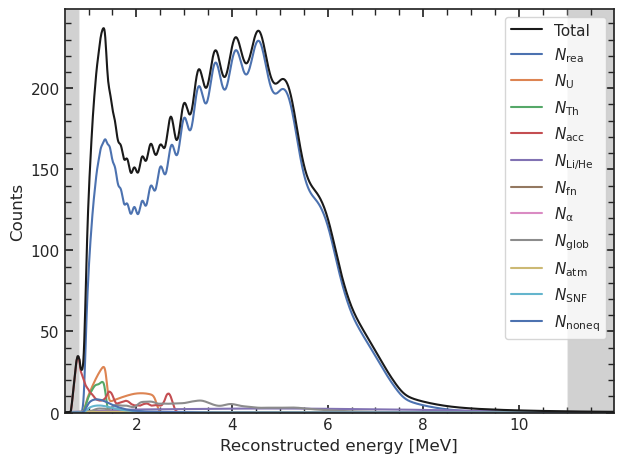

In [2]:
model = orsa.model.read_json('inputs/test_model.json')
model.exposure = 6*365.25
model

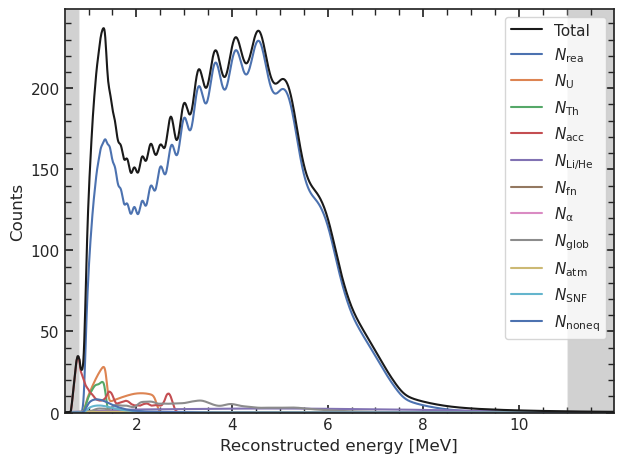

In [3]:
model

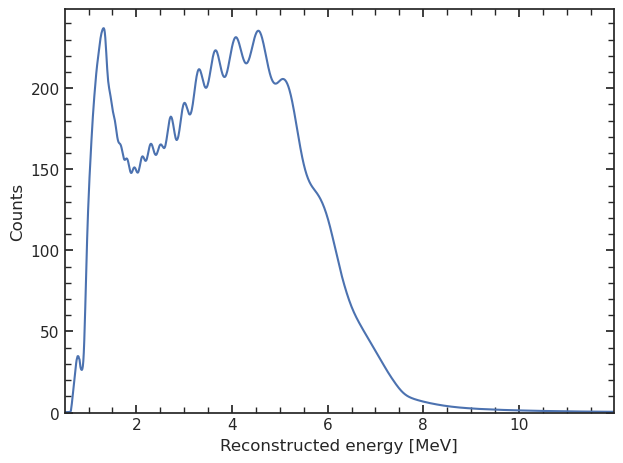

In [4]:
data = model.get_spectrum(asimov = True)
data

In [5]:
# for param in model.detector_parameters:
#     model.detector_parameters[param].fixed = True

# for param in model.core_parameters:
#     model.core_parameters[param].fixed = True

# for param in model.normalization_parameters:
#     if model.normalization_parameters[param].label != 'rea':
#         model.normalization_parameters[param].fixed = True

for param in model.parameters:
    if param != 'rea' and param not in model.oscillation_parameters:
        model.parameters[param].fixed = True

model.parameters['rho'].fixed = True


In [6]:
init_model = model.copy()
model.use_shape_uncertainty = False
cf = orsa.probability.CostFunction(ll=orsa.probability.ll_binned, model=model, data=data, ll_args = dict())
true_values = cf.get_params_to_fit()[0]
res = orsa.fit.minuit(cf)
res.true_values = true_values

Cost function parsed as LogLikelihood-like


In [7]:
# Prepare priors for NestedSampling mapping

init_params, labels, init_errors, formatted_labels, _ = cf.get_params_to_fit()

for j, label in enumerate(labels):
    for i, model_ in enumerate(cf.model):
            for el in model_.parameters:
                param = model_.parameters[el]
                if f"{param.label}:{param.group}" not in labels:
                    if el in cf.lp_args[i]:
                        del cf.lp_args[i][el]

                if label == f"{param.label}:{param.group}":
                    if el in cf.lp_args[i]:
                        keys_ = list(cf.lp_args[i][el].keys())
                        if (('gauss' in cf.lp_args[i][el]) or ('flat' in cf.lp_args[i][el])) and (len(cf.lp_args[i][el]) == 1):
                            pass
                        elif (('gauss' in cf.lp_args[i][el]) or ('flat' in cf.lp_args[i][el])) and (len(cf.lp_args[i][el]) > 1):
                            if ('gauss' in cf.lp_args[i][el]):
                                for elll in keys_:
                                    if elll != 'gauss': del cf.lp_args[i][el][elll]
                            elif ('flat' in cf.lp_args[i][el]):
                                for elll in keys_:
                                    if elll != 'flat': del cf.lp_args[i][el][elll]

                            else:
                                del cf.lp_args[i][el]
                                cf.add_prior(param.label, 'flat', dict(left = res.obj.values[label] - 4*res.obj.errors[label], right = res.obj.values[label] + 4*res.obj.errors[label]), which_cf=i)
                            
                    else:
                        cf.add_prior(param.label, 'flat', dict(left = res.obj.values[label] - 4*res.obj.errors[label], right = res.obj.values[label] + 4*res.obj.errors[label]), which_cf=i)

cf.lp_args


array([{'rea': {'gauss': {'mean': 289459.05819689727, 'sigma': 5789.181163937947}}, 'dm2_21': {'flat': {'left': 7.476379343135082e-05, 'right': 7.583620656864919e-05}}, 'dm2_31': {'flat': {'left': 0.002511595584572908, 'right': 0.0025450044154270916}}, 's2_12': {'flat': {'left': 0.3013588942468496, 'right': 0.3126411057531504}}, 's2_13': {'flat': {'left': 0.012174407982154533, 'right': 0.03142559201784546}}}],
      dtype=object)

In [8]:
nested_path = 'inputs/test_nested.h5'
if os.path.isfile(nested_path):
    pass
    # res_mcmc = orsa.fit.parse_emcee(mcmc_path)
    # res_mcmc.labels = res_minuit.labels
    # res_mcmc.formatted_labels = res_minuit.formatted_labels
    # res_mcmc.true_values = res_minuit.true_values
    # res_mcmc.cost_function = res_minuit.cost_function
else:
    res_nested = orsa.fit.dynesty(cf, 1000, backend=None, dynesty_kwargs=dict(bound='multi'))
    res_nested.true_values = res.true_values

Cost function parsed as LogLikelihood-like


16164it [09:54, 27.19it/s, batch: 2 | bound: 1 | nc: 1 | ncall: 58267 | eff(%): 27.098 | loglstar: -2991.920 < -2988.012 < -2991.256 | logz: -2994.006 +/-  0.053 | stop:  0.895]       


In [9]:
res_nested.get_samples(100000000000)
res_nested.to_json('inputs/test_nested.json')
orsa.utils.to_file(res_nested, 'inputs/test_nested.dill')

Only 16164 in chain!


/home/ubuntu/miniconda3/lib/python3.11/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


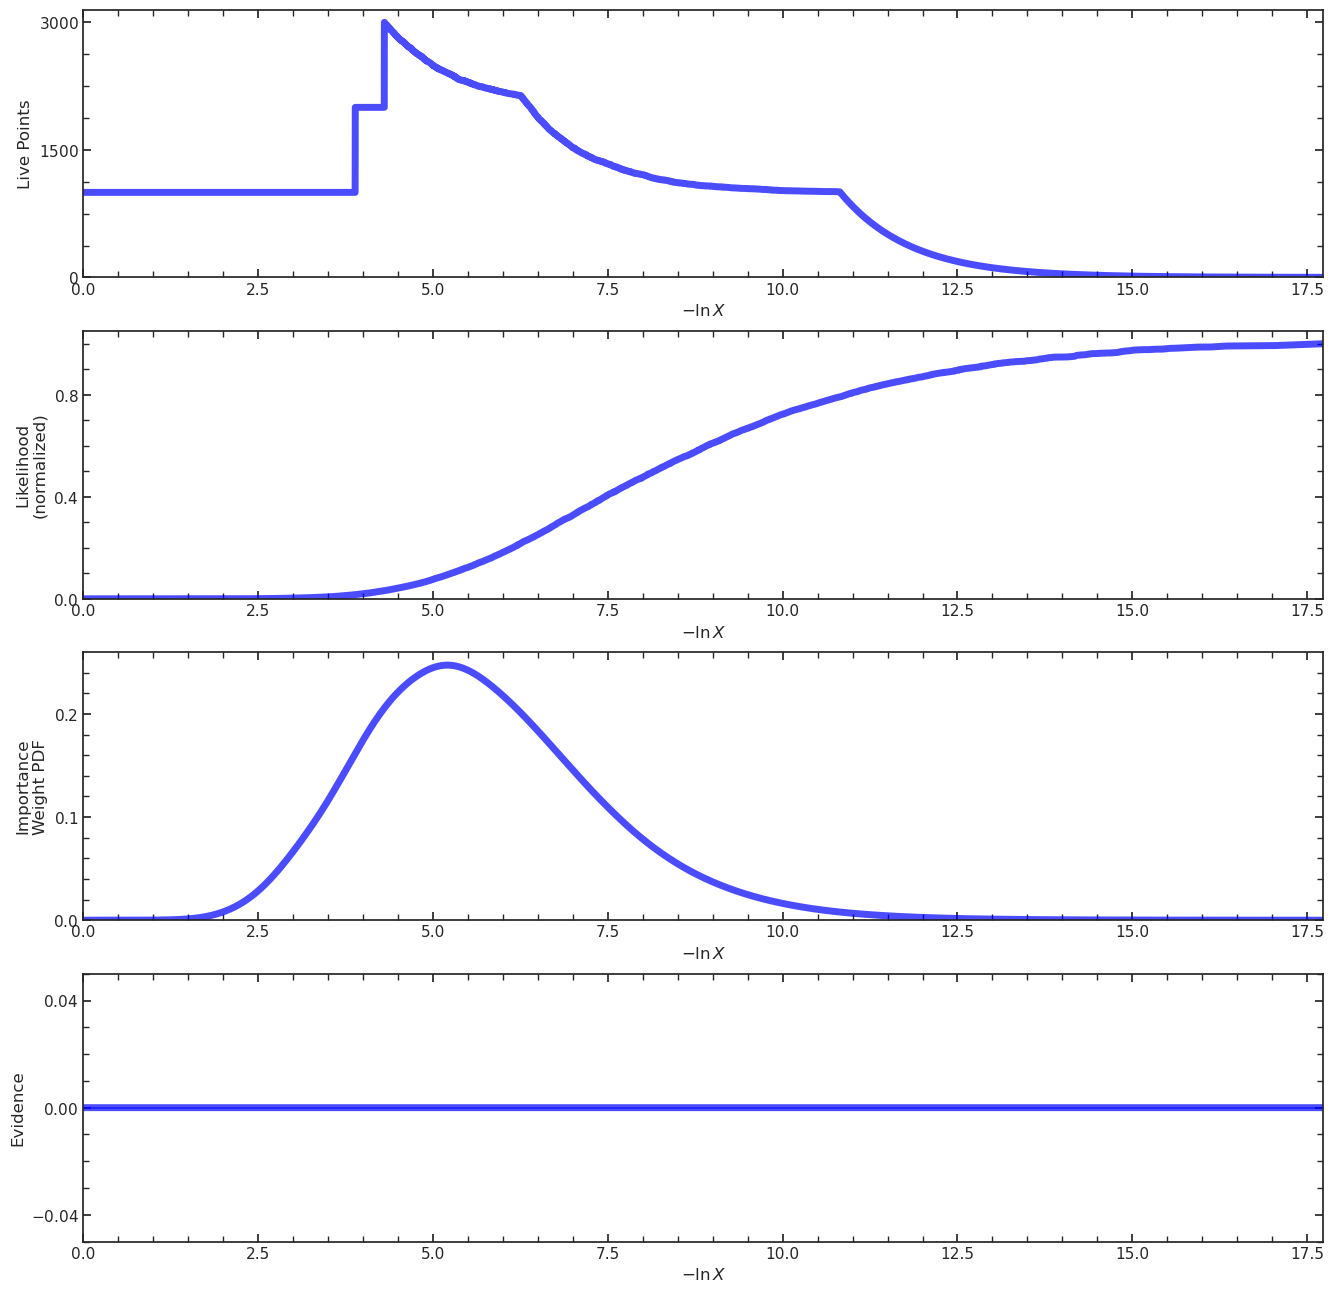

In [10]:
from dynesty import plotting as dyplot

fig, axes = dyplot.runplot(res_nested.obj.results)  # summary (run) plot

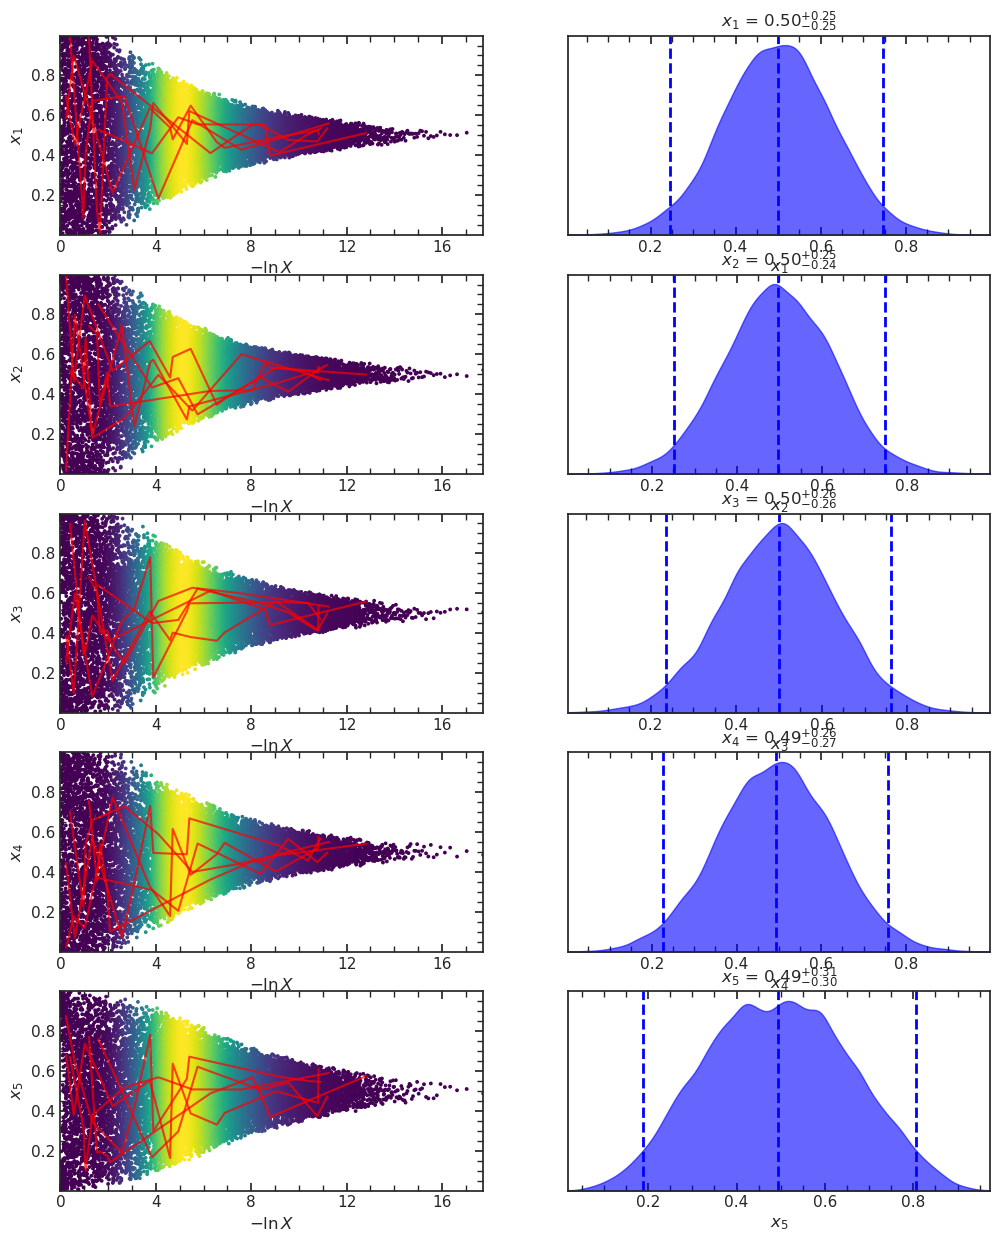

In [11]:
fig, axes = dyplot.traceplot(res_nested.obj.results, #truths=np.zeros(ndim),
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             connect_highlight=range(5))

In [12]:
res_nested.obj.results.niter

16164

In [13]:
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# # plot 6 snapshots over the course of the run
# for i, a in enumerate(axes.flatten()):
#     it = int((i+1)*res_nested.obj.results.niter/6.1)
#     print(it)
#     # overplot the result onto each subplot
#     done = False
    
#     while not done:
#         try:
#             temp = dyplot.boundplot(res_nested.obj.results, dims=(0, 1), it=it,
#                                     prior_transform=orsa.fit.placeholder,
#                                     max_n_ticks=3, show_live=True,
#                                     span=[(0, 1), (0, 1)],
#                                     fig=(fig, a))
#             done = True
#         except:
#             it+=1

#     a.set_title('Iteration {0}'.format(it), fontsize=26)
# fig.tight_layout()

2649
5299
7949
10599
13249


15899
